# **Train**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout ,Concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import cv2
from google.colab import drive
import pandas as pd
import pickle

drive.mount('/content/drive')
%matplotlib inline

#_______________________________________________________________________________
path        = "/content/drive/My Drive/ATI/CNN_Dataset/"
TRAIN_DIR   = path + "train/"
VALID_DIR   = path + "test/"
occupied_dir= path + "test/Occupied/*.jpg"
empty_dir   = path + "test/Empty/*.jpg"
trainCSV_dir= path + "train.csv"
testCSV_dir = path + "test.csv"
valid_images= glob(occupied_dir) + glob(empty_dir)

#_______________________________________________________________________________
HEIGHT = 37
WIDTH = 49
BATCH_SIZE = 32
nb_train_samples = 5000
nb_validation_samples = 500
batch_size =  8
epochs = 5

#_______________________________________________________________________________
pickle_in = open(TRAIN_DIR +"labels.pickle","rb")
train_labels = pickle.load(pickle_in)

pickle_in = open(TRAIN_DIR +"numricalData.pickle","rb")
train_numricalData = pickle.load(pickle_in)

pickle_in = open(TRAIN_DIR +"imgData.pickle","rb")
train_imgData = pickle.load(pickle_in)
#___________

pickle_in = open(VALID_DIR +"labels.pickle","rb")
test_labels = pickle.load(pickle_in)

pickle_in = open(VALID_DIR +"numricalData.pickle","rb")
test_numricalData = pickle.load(pickle_in)

pickle_in = open(VALID_DIR +"imgData.pickle","rb")
test_imgData = pickle.load(pickle_in)
#_______________________________________________________________________________
'''
VGG16
'''
VGG = VGG16(weights='imagenet', include_top=False, input_shape=(HEIGHT,WIDTH,3) )
for layer in VGG.layers:
        layer.trainable = False
'''
ResNet50
'''
ResNet = ResNet50(weights='imagenet', include_top=False,input_shape=(HEIGHT,WIDTH,3) )       
for layer in ResNet.layers:
        layer.trainable = False
#_________________________________ right branch
VGG_output = VGG.output
VGG_output = Flatten()(VGG_output)
VGG_output = Dense(256, activation='relu')(VGG_output)
VGG_output = Dropout(0.3)(VGG_output)

ResNet_output = ResNet.output
ResNet_output = Flatten()(ResNet_output)
ResNet_output = Dense(256, activation='relu')(ResNet_output)
ResNet_output = Dropout(0.3)(ResNet_output)

visual = Concatenate()([VGG_output, ResNet_output])
visual = Dense(256, activation='relu')(visual)

#_________________________________ left branch
numricalModel = Sequential() 
numricalModel.add(Dense(64, kernel_initializer = 'normal', activation = 'relu',input_shape = (6,))) 
numricalModel.add(Dense(64, activation = 'relu'))

#_________________________________ aggregate
Feature = Concatenate()([numricalModel.output, visual])
Feature= Dense(200, activation='relu')(Feature)
Feature= Dropout(0.3)(Feature)

pred = Dense(1, activation='sigmoid')(Feature)

#_________________________________ final Model
tf_model = Model(inputs=[numricalModel.input,[VGG.input,ResNet.input]], outputs=pred)
tf_model.compile(loss='binary_crossentropy',optimizer=SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

parknet = tf_model.fit(
    [train_numricalData, [train_imgData,train_imgData]], 
    train_labels,
    validation_data=([test_numricalData, [test_imgData,test_imgData]], test_labels),
    epochs=epochs, 
    batch_size=8,
    verbose=1)

print("     ______________________Done____________________________")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
94773248/94765736 [==============================] - 2s 0us/step
Epoch 1/5
348/348 [==============================] - 8s 23ms/step - loss: 0.5598 - accuracy: 0.8801 - val_loss: 0.2071 - val_accuracy: 0.9360
Epoch 2/5
348/348 [==============================] - 6s 17ms/step - loss: 0.1567 - accuracy: 0.9579 - val_loss: 0.2101 - val_accuracy: 0.9160
Epoch 3/5
348/348 [==============================] - 6s 17ms/step - loss: 0.1103 - accuracy: 0.9611 - val_loss: 0.1

In [0]:
 plt.figure(1, figsize = (20,12)) 
 
#________________________________
plt.subplot(221)  
plt.plot(parknet.history['accuracy'])  
plt.plot(parknet.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

#________________________________________________
plt.subplot(222)  
plt.plot(parknet.history['loss'])  
plt.plot(parknet.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

In [0]:
valid_images = test_imgData
ground_truth = test_labels
prediction = []

i = 0
for img in valid_images:
    i +=1
    if i%10==0 :
        print("[{0}/{1}] ".format(i ,len(valid_images)))

    pred = tf_model.predict([test_numricalData,[test_imgData, test_imgData]])
    pred = np.squeeze(pred)
    if pred[0] > 0.98:
        prediction.append(1)
    else:
        prediction.append(0)

print("__________DONE__________")

### Validate the model

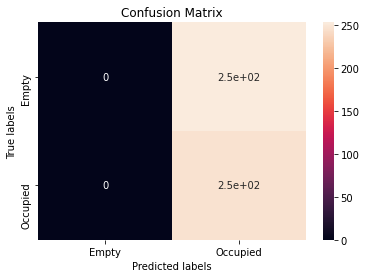

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Show the classification metrics
# print(classification_report(ground_truth, prediction, target_names=['Empty', 'Occupied']))

# confusion matrix
cm = confusion_matrix(ground_truth, prediction)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Empty', 'Occupied']); 
ax.yaxis.set_ticklabels(['Empty', 'Occupied']);